# Anchor-Probe/Probe-Probe/Anchor-Anchor Hidden Distance
**Goal**: Analyze the distance between the hidden representation of anchors and their probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Anchors and Probes Data

In [2]:
LAYER = 'hidden'

In [3]:
# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')
anchor_probe_mapping = anchor_probe_mapping.rename(columns={'probes': 'probe'})
anchor_probe_mapping.head()

,anchor,probe,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


In [4]:
all_anchors_data = []
all_probes_data = []


for dilution in tqdm(range(1, 4)):
    # ANCHORS
    anchor_list = sum(anchor_probe_mapping['anchor'].apply(lambda x: x[:dilution]).tolist(), [])
    anchor_types = [f"ANC_{i}" for i in ['REG', 'EXC', 'AMB']]
    
    anchor_data = pd.concat([pd.read_pickle(f'pmsp-recurrent-dt-100-seed-1/activations-anchors-{LAYER}.pkl'),
                             pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-{LAYER}.pkl')])
    
    anchor_data = anchor_data[anchor_data['word_type'].isin(anchor_types)]
    anchor_data = anchor_data[anchor_data['orth'].isin(anchor_list)]
    anchor_data = anchor_data.drop_duplicates(subset=['epoch', 'orth'])
    anchor_data['dilution'] = dilution
    all_anchors_data.append(anchor_data)
    
    # PROBES
    probe_types = [f"PRO_{i}" for i in ['REG', 'EXC', 'AMB']]
    
    probe_data = pd.concat([pd.read_pickle(f'pmsp-recurrent-dt-100-seed-1/activations-probes-{LAYER}.pkl'),
                            pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-{LAYER}.pkl')])
    
    probe_data = probe_data[probe_data['word_type'].isin(probe_types)]
    probe_data = probe_data.drop_duplicates(subset=['epoch', 'orth'])
    probe_data['dilution'] = dilution
    all_probes_data.append(probe_data)

all_anchors_data = pd.concat(all_anchors_data).reset_index(drop=True)
all_probes_data = pd.concat(all_probes_data).reset_index(drop=True)

100%|██████████| 3/3 [00:10<00:00,  3.63s/it]


In [5]:
all_anchors_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution
0,0,"[0.5810385, 0.03448805, 0.7988132, 0.9942407, ...",0,slit,slit,ANC_REG,1
1,0,"[0.5104707, 0.2259514, 0.4384914, 0.9883878, 0...",34,drace,dro,ANC_EXC,1
2,0,"[0.7540455, 0.4483854, 0.2318757, 0.99431, 0.4...",8,shing,SiN,ANC_REG,1
3,0,"[0.4388078, 0.1719238, 0.6234508, 0.9161762, 0...",39,suff,sUf,ANC_EXC,1
4,0,"[0.2659034, 0.02671888, 0.1501291, 0.9853213, ...",36,geam,jem,ANC_EXC,1


In [6]:
anchor_probe_mapping.head()

,anchor,probe,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


## Calculation of Distance between Anchors and Probes

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [7]:
results = []
for dilution in [1, 2, 3]:
    anchors_data = all_anchors_data[all_anchors_data['dilution'] == dilution]
    probes_data = all_probes_data[all_probes_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        anchor_hidden = anchors_data[anchors_data['orth'].isin(row['anchor'])]
        probes_hidden = probes_data[probes_data['orth'].isin(row['probe'])]

        min_epoch = min(anchor_hidden['epoch'].unique())
        max_epoch = max(anchor_hidden['epoch'].unique())

        for epoch in [100, 2000, max_epoch]:
            epoch_anchor_hidden = np.array(anchor_hidden[anchor_hidden['epoch'] == epoch]['hidden'].tolist())
            epoch_probe_hidden = np.array(probes_hidden[probes_hidden['epoch'] == epoch]['hidden'].tolist())

            results.append({
                'epoch': epoch,
                'dilution': dilution,
                'anchor': row['anchor'],
                'probes': row['probe'],
                'type': row['type'],
                'ap_cosine_distances': cosine_distances(epoch_anchor_hidden, epoch_probe_hidden),
                'ap_l1_distances': manhattan_distances(epoch_anchor_hidden, epoch_probe_hidden),
                'aa_cosine_distances': cosine_distances(epoch_anchor_hidden, epoch_anchor_hidden),
                'aa_l1_distances': manhattan_distances(epoch_anchor_hidden, epoch_anchor_hidden),
                'pp_cosine_distances': cosine_distances(epoch_probe_hidden, epoch_probe_hidden),
                'pp_l1_distances': manhattan_distances(epoch_probe_hidden, epoch_probe_hidden),
            })

Dilution 3: 100%|██████████| 27/27 [00:00<00:00, 112.07it/s]


In [8]:
results_df = pd.DataFrame(results)
results_df['mean_ap_cosine_distance'] = results_df['ap_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_ap_l1_distance'] = results_df['ap_l1_distances'].apply(lambda x: x.mean())
results_df['mean_aa_cosine_distance'] = results_df['aa_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_aa_l1_distance'] = results_df['aa_l1_distances'].apply(lambda x: x.mean())
results_df['mean_pp_cosine_distance'] = results_df['pp_cosine_distances'].apply(lambda x: x.mean())
results_df['mean_pp_l1_distance'] = results_df['pp_l1_distances'].apply(lambda x: x.mean())
results_df['first_anchor'] = results_df['anchor'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['type', 'first_anchor']).reset_index(drop=True)

In [9]:
results_df.head()

,epoch,dilution,anchor,probes,type,ap_cosine_distances,ap_l1_distances,aa_cosine_distances,aa_l1_distances,pp_cosine_distances,pp_l1_distances,mean_ap_cosine_distance,mean_ap_l1_distance,mean_aa_cosine_distance,mean_aa_l1_distance,mean_pp_cosine_distance,mean_pp_l1_distance,first_anchor
0,100,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.13823260073711618, 0.12092682098243068, 0....","[[24.41849562000001, 22.135643893000008, 23.78...",[[0.0]],[[0.0]],"[[0.0, 0.09995369257830433, 0.1263671733463245...","[[0.0, 20.028094392999993, 21.142562927000004,...",0.134934,23.711665,0.000000,0.000000,0.079639,14.813202,blome
1,2000,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.13159676897731232, 0.16936000680234642, 0....","[[24.698169349912, 28.53793360492101, 25.61953...",[[0.0]],[[0.0]],"[[0.0, 0.1387687052140396, 0.07250178465785118...","[[0.0, 25.247931406667, 16.395752275046004, 24...",0.148571,26.248899,0.000000,0.000000,0.086870,16.647735,blome
2,3850,1,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.21800335122961934, 0.2517655129697125, 0.2...","[[17.6476583691789, 19.684967321685605, 20.882...",[[0.0]],[[0.0]],"[[0.0, 0.20273377411305427, 0.2883885563793771...","[[0.0, 17.0343099752873, 21.1028184383057, 18....",0.255847,19.996887,0.000000,0.000000,0.172710,13.574625,blome
3,100,2,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.12122244745724275, 0.1003708624676618, 0.1...","[[21.980566715999995, 19.928482208999988, 21.9...","[[0.0, 0.057115449819493236], [0.0571154498194...","[[0.0, 14.612012975999999], [14.61201297599999...","[[0.0, 0.09995369257830433, 0.1263671733463245...","[[0.0, 20.028094392999993, 21.142562927000004,...",0.127771,22.708624,0.028558,7.306006,0.079639,14.813202,blome
4,2000,2,"[blome, clome, flome]","[stome, shome, grome, prome]",AMB,"[[0.12346282211264592, 0.1282666072410401, 0.1...","[[23.7680875311915, 23.718735348270506, 23.074...","[[0.0, 0.09923020692111895], [0.09923020692111...","[[0.0, 19.995224071071494], [19.99522407107149...","[[0.0, 0.1387687052140396, 0.07250178465785118...","[[0.0, 25.247931406667, 16.395752275046004, 24...",0.134390,24.658219,0.049615,9.997612,0.086870,16.647735,blome


## Mean Cosine and L1 Distance by Anchor/Probe Type

This first pair of graphs aggregate all three dilution levels together. The idea is that each anchor/probe set is weighted equally, and the dilution levels are weighted equally - i.e. each point of the curve is composed of 30 datapoints (3 dilution levels times 10 anchor sets) for REG/EXC and 21 datapoints for ambiguous.

The error bands are based on a confidence interval. The confidence interval being plotted is the 68% confidence interval - which approximately corresponds to standard error.

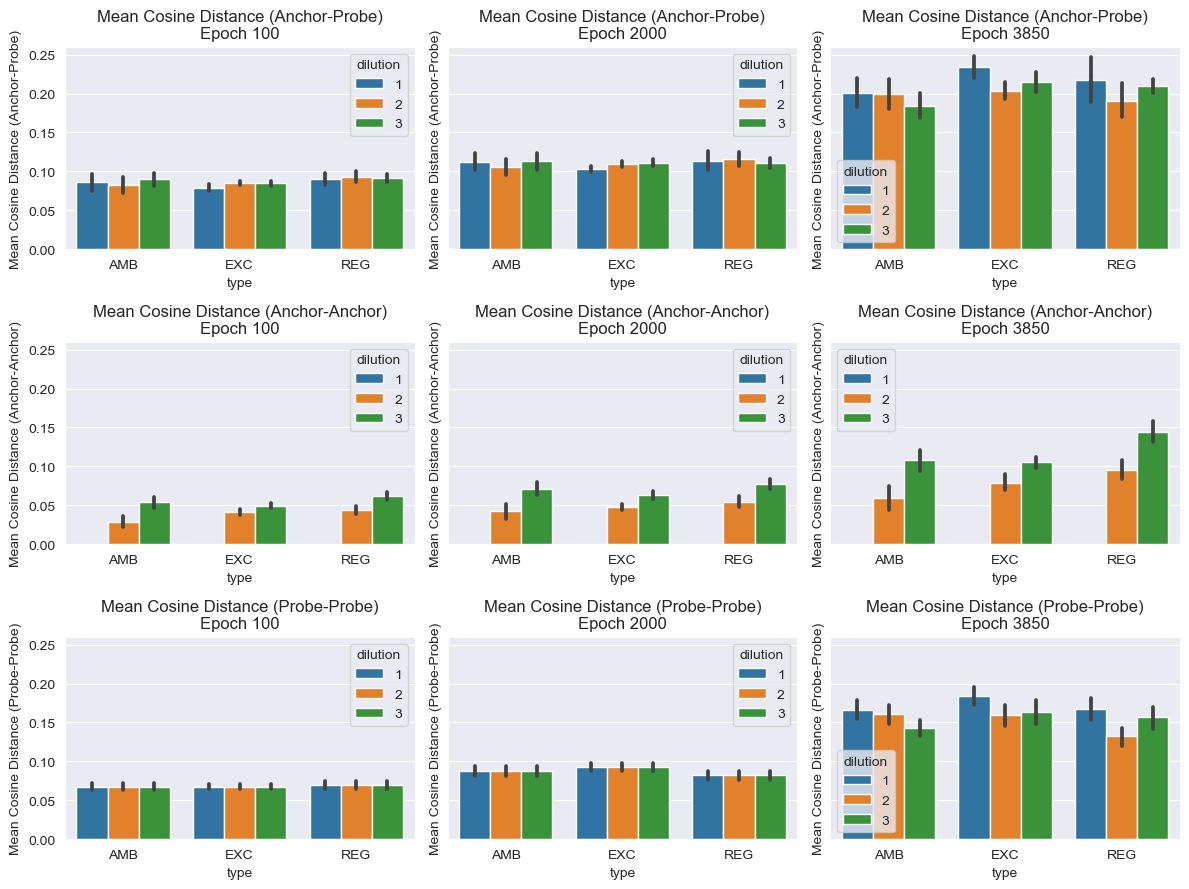

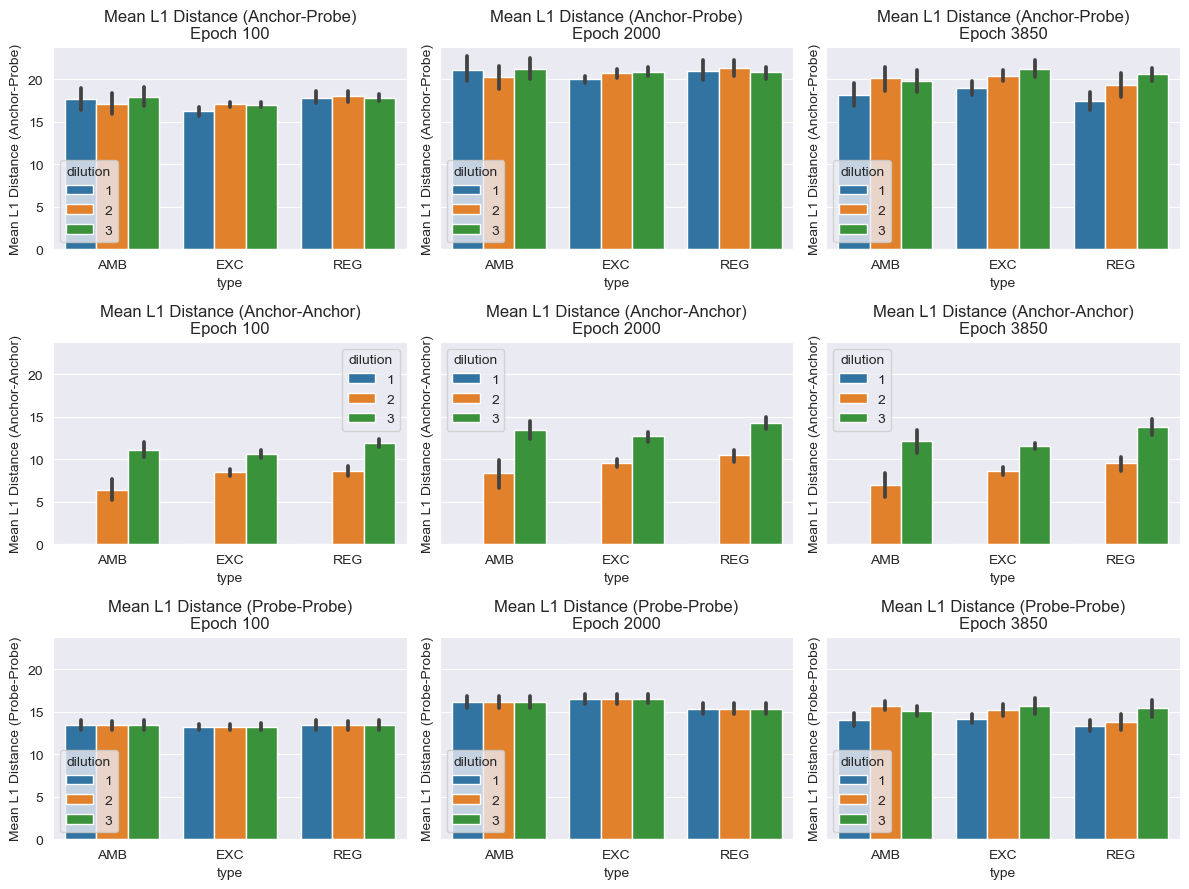

In [10]:
distance_mapping = {
    'aa': 'Anchor-Anchor',
    'ap': 'Anchor-Probe',
    'pp': 'Probe-Probe'
}

min_epoch = all_anchors_data['epoch'].min()
max_epoch = all_anchors_data['epoch'].max()

for metric in ['cosine', 'l1']:
    fig, axs = plt.subplots(3, 3, figsize=(12, 9), sharey='all')

    for distance, ax in zip(['ap', 'aa', 'pp'], axs):
        for epoch, sub_ax in zip([100, 2000, max_epoch], ax):
            sns.barplot(data=results_df[results_df['epoch'] == epoch], x='type',
                        y=f'mean_{distance}_{metric}_distance',
                        hue='dilution', ax=sub_ax, ci=68)
            sub_ax.set_ylabel(f'Mean {metric.title()} Distance ({distance_mapping[distance]})')
            sub_ax.set_title(f'Mean {metric.title()} Distance ({distance_mapping[distance]})\nEpoch {epoch}')



    plt.tight_layout()
    plt.show()